In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
from logging import Logger
from typing import Optional

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":          # notebook opened from ./notebooks
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import importlib

from src_clean.data_pipelines.silver.market_volatility_processor import VolatilityProcessor
importlib.reload(sys.modules["src_clean.data_pipelines.silver.market_volatility_processor"])

from src_clean.training.xgboost_training_pipeline_mlflow import XGBoostMLflowTrainingPipeline
importlib.reload(sys.modules["src_clean.training.xgboost_training_pipeline_mlflow"])
from src_clean.training.xgboost_training_pipeline_mlflow import XGBoostMLflowTrainingPipeline


In [2]:
train_csv = '../data_clean/gold/market/features/spx500_features.csv'
train_news = '../data_clean/Latest Gold/news/signals/spx500_news_signals.csv'

Xraw = pd.read_csv(train_csv)
Xnews = pd.read_csv(train_news)

In [3]:
pipeline = XGBoostMLflowTrainingPipeline(
    market_features_path=Path('../data_clean/gold/market/features/spx500_features.csv'),
    labels_path=None,
    news_signals_path=Path('../data_clean/gold/news/signals/spx500_news_signals.csv'),
    prediction_horizon_minutes=30,
    output_dir=Path('./xgb_test'),
    task='regression',
    experiment_name='sp500_prediction',
    enable_tuning=True,
    stage1_n_trials=3,
    stage2_n_trials=3
)

In [4]:
market_df, news_df = pipeline.load_data()

# Validate labels are present
market_df = pipeline.validate_labels(market_df)

# Merge with news
combined_df = pipeline.merge_market_news(market_df, news_df)

# Prepare features
X, y, time_index, feature_names = pipeline.prepare_features(combined_df)

2025-11-02 03:09:45,004 - INFO - Loading data from Gold layer...
2025-11-02 03:10:01,076 - INFO - Loaded market features: 2625395 rows, 71 columns
2025-11-02 03:10:01,078 - INFO - Inferred labels path: ..\data_clean\gold\market\labels\spx500_labels_30min.csv
2025-11-02 03:10:05,453 - INFO - Loaded gold labels: 2625365 rows, 11 columns
2025-11-02 03:10:05,454 - INFO - Merging market features with gold labels...
2025-11-02 03:10:06,198 - INFO - Merged dataset: 2625365 rows after merging
2025-11-02 03:10:06,278 - INFO - Loaded news signals: 16233 rows, 11 columns
2025-11-02 03:10:06,468 - INFO - Validating labels for 30-minute prediction...
2025-11-02 03:10:07,549 - INFO - Valid samples with labels: 2625365
2025-11-02 03:10:07,579 - INFO - Target stats: mean=0.000794, std=0.130459
2025-11-02 03:10:08,737 - INFO - Merging market features with news signals. Market Feature Initial Shape: (2625365, 76)
2025-11-02 03:10:10,167 - INFO - Merged dataset shape: (2625365, 90)
2025-11-02 03:10:10,17

In [5]:
model, metrics = pipeline.train_model(X, y, time_index, feature_names)

2025-11-02 03:10:22,363 - INFO - Training XGBoost model with MLflow tracking...
2025-11-02 03:10:22,363 - INFO - 
2025-11-02 03:10:22,363 - INFO - TEMPORAL DATA SPLITTING
2025-11-02 03:10:22,363 - INFO - ================================================================================
2025-11-02 03:10:22,904 - INFO - Total samples: 2625365
2025-11-02 03:10:22,908 - INFO - Train: 1575219 samples (60%) | 2020-10-13 16:25:00+00:00 to 2023-10-12 14:03:00+00:00
2025-11-02 03:10:22,908 - INFO - Val:   525073 samples (20%) | 2023-10-12 14:04:00+00:00 to 2024-10-11 05:16:00+00:00
2025-11-02 03:10:22,908 - INFO - Test:  262536 samples (10%) | 2024-10-11 05:17:00+00:00 to 2025-04-11 12:52:00+00:00
2025-11-02 03:10:22,908 - INFO - OOT:   262537 samples (10%) | 2025-04-11 12:53:00+00:00 to 2025-10-10 20:29:00+00:00
2025-11-02 03:10:22,908 - INFO - ================================================================================

2025-11-02 03:10:24,094 - INFO - Performing hyperparameter tuning on tr

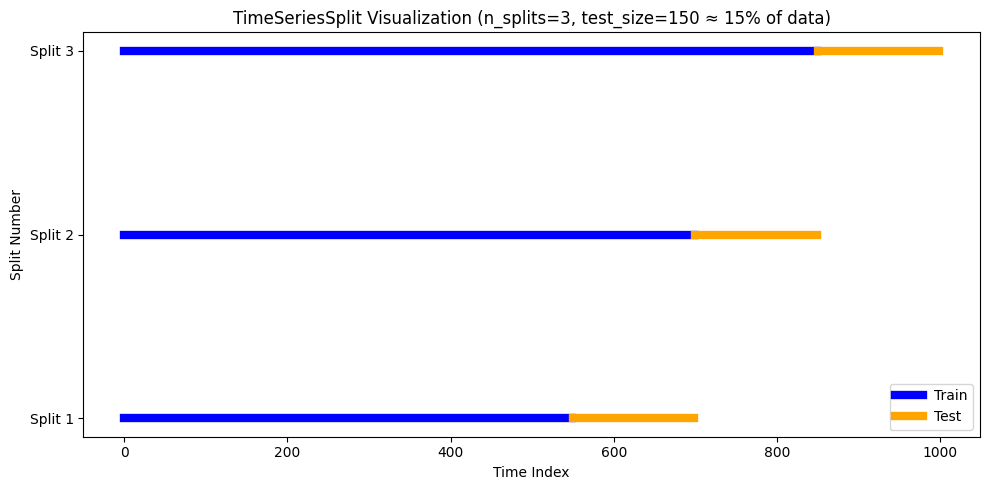

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Synthetic time series
n_samples = 1000
X = np.arange(n_samples)

# Create TimeSeriesSplit (you used this instead of SlidingWindowSplit)
test_size = int(0.15 * n_samples)
splitter = TimeSeriesSplit(n_splits=3, test_size=test_size)

# Visualize the splits
fig, ax = plt.subplots(figsize=(10, 5))

for i, (train_idx, test_idx) in enumerate(splitter.split(X)):
    ax.plot(train_idx, [i]*len(train_idx), c='blue', lw=6, label='Train' if i == 0 else "")
    ax.plot(test_idx, [i]*len(test_idx), c='orange', lw=6, label='Test' if i == 0 else "")

# Dynamic title text
train_example_len = len(train_idx) - len(test_idx)
title_text = (
    f"TimeSeriesSplit Visualization "
    f"(n_splits={splitter.n_splits}, test_size={test_size} "
    f"≈ {test_size/n_samples:.0%} of data)"
)

ax.legend()
ax.set(
    yticks=range(i+1),
    yticklabels=[f"Split {j+1}" for j in range(i+1)],
    xlabel="Time Index",
    ylabel="Split Number",
    title=title_text
)

plt.tight_layout()
plt.show()
